In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import os

Create an index of the papers used for labelling.

The idea will be to have multiple index files, with N papers in each file.

A new index can be created, with random papers in it, that are not already in use in other index files.

In [2]:
project_dir = Path.cwd().parent.parent
print("project_dir:", project_dir)

project_dir: /home/tim/Documents/arxiv-code-search


Functions:

In [3]:
def load_metadata_csv(metadata_file_path):
    """
    Load arxiv metadata csv file.
    Originally extracted from arxiv-metadata-oai-snapshot.json
    """

    dtypes_dict = {
        'id': str, 
        'submitter': str, 
        'authors': str, 
        'title': str, 
        'comments': str, 
        'journal-ref': str, 
        'doi': str,
        'report-no': str, 
        'categories': str, 
        'license': str, 
        'abstract': str, 
        'versions': str,
        'authors_parsed': str,
    }

    # if metadata_file_path ends in .gz, use gzip in pandas
    if metadata_file_path.suffix == '.gz':
        df = pd.read_csv(metadata_file_path, dtype=dtypes_dict, parse_dates=['update_date'], compression='gzip')
    else:
        df = pd.read_csv(metadata_file_path, dtype=dtypes_dict, parse_dates=['update_date'])

    # parse "versions" and "authors_parsed" columns with eval
    df["versions"] = df["versions"].apply(eval)
    df["authors_parsed"] = df["authors_parsed"].apply(eval)

    return df

def filter_by_category(df, regex_pattern_cat=None):
    """
    Filter out papers based on categories using regex

    e.g regex_pattern_cat = "cs|eess"
    """
    # regex pattern to match categories (is a string)
    if regex_pattern_cat is None:
        return df
    else:
        # filter out papers based on categories using regex
        return df[df["categories"].str.contains(regex_pattern_cat, regex=True)]

def filter_by_date(df, start_date=None, end_date=None):
    """
    Filter out papers based on start and end dates
    """
    # filter out papers based on start and end dates
    if start_date is None and end_date is None:
        return df
    elif start_date is None:
        return df[(df["update_date"] <= end_date)]
    elif end_date is None:
        return df[(df["update_date"] >= start_date)]
    else:
        return df[(df["update_date"] >= start_date) & (df["update_date"] <= end_date)]

def filter_by_license(df, license_filter_list=None):
    """
    Filter by license.
    """

    # dict to match license in df
    license_type_dict = {
        "ARXIV": "http://arxiv.org/licenses/nonexclusive-distrib/1.0/",
        "CC BY 4.0": "http://creativecommons.org/licenses/by/4.0/",
        "CC BY-NC-SA 4.0": "https://creativecommons.org/licenses/by-nc-sa/4.0/",
        "CC BY 3.0": "https://creativecommons.org/licenses/by/3.0/",
        "CC BY-NC-ND 4.0": "https://creativecommons.org/licenses/by-nc-nd/4.0/",
        "CC0 1.0": "https://creativecommons.org/publicdomain/zero/1.0/",
        "CC BY-NC-SA 3.0": "https://creativecommons.org/licenses/by-nc-sa/3.0/",
        "CC BY-SA 4.0": "https://creativecommons.org/licenses/by-sa/4.0/",
        "CC": "https://creativecommons.org/publicdomain/",
    }

    if license_filter_list is None:
        return df
    else:

        # make all items in license_filter_list upper case
        license_filter_list = [x.upper() for x in license_filter_list]

        # match license in license_filter_list to the name of the license in the df
        license_filter_list = [license_type_dict[x] for x in license_filter_list]

        # filter by license
        return df[df["license"].isin(license_filter_list)]

def select_random_articles(df, index_file_dir, check_duplicates=True, save_csv=True, save_name=None, n_articles=10):
    """
    Select n random articles from df, and ensure
    that they are not duplicated in other 'index_of_labels' csvs.
    """

    # get a list of the csv file names
    files = os.listdir(index_file_dir)

    file_list = [
        Path(index_file_dir) / filename
        for filename in files
        if filename.endswith(".csv")
        ]

    no_exisiting_index_files = len(file_list)

    if check_duplicates and no_exisiting_index_files > 0:
        # load index files with pandas and append to index_data_list
        index_data_list = []
        for file in file_list:
            index_data_list.append(load_metadata_csv(file))

        # concatenate index_data_list into one dataframe
        df_used = pd.concat(index_data_list).reset_index(drop=True)

        # concatenate df and df_used
        df_unique = pd.concat([df, df_used], sort=False).drop_duplicates(["id"], keep=False)
    else:
        df_unique = df

    # select random articles
    # check for edge cases where n_articles > df_unique.shape[0]
    # or when df_unique.shape[0] is 0
    if df_unique.shape[0] == 0:
        print("No unique articles to select from.")
        return None
    elif n_articles > df_unique.shape[0]:
        pass
    else:
        df_unique = df_unique.sample(n_articles)

    # save df_unique to csv if save_csv is True
    if save_csv:
        if save_name is None:
            save_name = f"index_of_articles_for_lables_{no_exisiting_index_files+1}.csv"
        save_path = index_file_dir / save_name
        df_unique.to_csv(save_path, index=False)

    return df_unique

In [4]:
# load metadata_sample.csv
metadata_file_path = project_dir / "notebooks/scratch" / "metadata_sample.csv"
df = load_metadata_csv(metadata_file_path)

In [33]:
df = load_metadata_csv(metadata_file_path)

# filter by category
# regex_pattern_cat = "cs|eess"
regex_pattern_cat = "stat.ML|cs"

df = filter_by_category(df, regex_pattern_cat)

# filter by date
start_date = "2020-08-01"
end_date = "2021-04-01"
df = filter_by_date(df, start_date=start_date, end_date=end_date)

# filter by license type
license_filter_list = ["cc by 4.0", "CC0 1.0"]
df = filter_by_license(df, license_filter_list=license_filter_list)

print("df.shape:", df.shape)
df.head()

df.shape: (46, 14)


,id,submitter,authors,title,comments,journal-ref,doi,report-no,categories,license,abstract,versions,update_date,authors_parsed
496,2012.04623,Alexander Ivchenko Vladimirovich,"Aleksandr Ivchenko, Pavel Kononyuk, Alexander ...",Study on the Assessment of the Quality of Expe...,"11 pages, 16 figures, 7 tables","Systems of Signal Synchronization, Generating ...",10.1109/SYNCHROINFO49631.2020.9166092,NaN,cs.MM cs.LG,http://creativecommons.org/licenses/by/4.0/,Dynamic adaptive streaming over HTTP provide...,"[{'version': 'v1', 'created': 'Tue, 8 Dec 2020...",2020-12-09,"[[Ivchenko, Aleksandr, ], [Kononyuk, Pavel, ],..."
917,2012.15374,Kasra Amini,"Blanca Belsa, Kasra Amini, Xinyao Liu, Aurelie...",Laser-induced electron diffraction of the ultr...,NaN,NaN,NaN,NaN,physics.chem-ph,http://creativecommons.org/licenses/by/4.0/,Visualizing molecular transformations in rea...,"[{'version': 'v1', 'created': 'Thu, 31 Dec 202...",2021-01-01,"[[Belsa, Blanca, ], [Amini, Kasra, ], [Liu, Xi..."
1764,2103.00288,Amir Gilad,"Daniel Deutch, Ariel Frankenthal, Amir Gilad, ...",On Optimizing the Trade-off between Privacy an...,NaN,NaN,NaN,NaN,cs.DB,http://creativecommons.org/licenses/by/4.0/,Organizations that collect and analyze data ...,"[{'version': 'v1', 'created': 'Sat, 27 Feb 202...",2021-03-02,"[[Deutch, Daniel, ], [Frankenthal, Ariel, ], [..."
1989,2012.00093,"J\""urgen Dieber","J\""urgen Dieber, Sabrina Kirrane",Why model why? Assessing the strengths and lim...,"13 pages, 4 figures",NaN,NaN,NaN,cs.LG,http://creativecommons.org/licenses/by/4.0/,When it comes to complex machine learning mo...,"[{'version': 'v1', 'created': 'Mon, 30 Nov 202...",2020-12-02,"[[Dieber, Jürgen, ], [Kirrane, Sabrina, ]]"
2318,2009.07404,Wenjian Hao,"Wenjian Hao, Rongyao Wang, Alexander Krolicki,...",Cell A* for Navigation of Unmanned Aerial Vehi...,NaN,NaN,NaN,11,cs.RO cs.SY eess.SY,http://creativecommons.org/licenses/by/4.0/,Proper path planning is the first step of ro...,"[{'version': 'v1', 'created': 'Wed, 16 Sep 202...",2020-09-17,"[[Hao, Wenjian, ], [Wang, Rongyao, ], [Krolick..."


In [12]:
index_file_dir = project_dir / "data/processed/labels/index_files"

# get a list of file names
files = os.listdir(index_file_dir)

file_list = [
    Path(index_file_dir) / filename
    for filename in files
    if filename.endswith(".csv")
]
file_list

[PosixPath('/home/tim/Documents/arxiv-code-search/data/processed/labels/index_files/index_of_labels_2.csv'),
 PosixPath('/home/tim/Documents/arxiv-code-search/data/processed/labels/index_files/index_of_labels_1.csv')]

In [29]:
index_data_list = []
for file in file_list:
    # load index file with pandas and append to index_data_list
    index_data_list.append(load_metadata_csv(file))

# concatenate index_data_list into one dataframe
df_used = pd.concat(index_data_list).reset_index(drop=True)
print(df_used.shape)

(20, 14)


In [31]:
df1 = pd.concat([df, df_used], sort=False).drop_duplicates(["id"], keep=False)
print("df1.shape:", df1.shape)

df1.shape: (52, 14)


In [57]:
df_unique = select_random_articles(df, index_file_dir, check_duplicates=True, save_csv=True, save_name=None, n_articles=10)

No unique articles to select from.


In [12]:
# randomly shuffle df and select 10 rows
df_sample = df.sample(frac=1).reset_index(drop=True)[:10]

# save df_sample as new csv file
index_file_dir = project_dir / "data/processed/labels/index_files"
save_name =  "index_of_labels_2.csv"

df_sample.to_csv(index_file_dir / save_name, index=False)


In [21]:
# get a list of file names
files = os.listdir(index_file_dir)

file_list = [
    Path(index_file_dir) / filename
    for filename in files
    if filename.endswith(".csv")
]

# find largest file number in file_list
np.max([int(str(i).split('.')[0].split('_')[-1]) for i in file_list])


2

# Scratch

In [27]:
# get the license
license_types = list(df["license"].unique())

['http://arxiv.org/licenses/nonexclusive-distrib/1.0/',
 nan,
 'http://creativecommons.org/licenses/by/4.0/',
 'http://creativecommons.org/licenses/by-nc-sa/4.0/',
 'http://creativecommons.org/licenses/by/3.0/',
 'http://creativecommons.org/licenses/by-nc-nd/4.0/',
 'http://creativecommons.org/publicdomain/zero/1.0/',
 'http://creativecommons.org/licenses/by-nc-sa/3.0/',
 'http://creativecommons.org/licenses/by-sa/4.0/',
 'http://creativecommons.org/licenses/publicdomain/']

In [36]:
"""
'http://arxiv.org/licenses/nonexclusive-distrib/1.0/',
 nan,
 'http://creativecommons.org/licenses/by/4.0/',
 'http://creativecommons.org/licenses/by-nc-sa/4.0/',
 'http://creativecommons.org/licenses/by/3.0/',
 'http://creativecommons.org/licenses/by-nc-nd/4.0/',
 'http://creativecommons.org/publicdomain/zero/1.0/',
 'http://creativecommons.org/licenses/by-nc-sa/3.0/',
 'http://creativecommons.org/licenses/by-sa/4.0/',
 'http://creativecommons.org/licenses/publicdomain/'

"""

license_type_dict = {
    "ARXIV": "http://arxiv.org/licenses/nonexclusive-distrib/1.0/",
    "CC BY 4.0": "http://creativecommons.org/licenses/by/4.0/",
    "CC BY-NC-SA 4.0": "https://creativecommons.org/licenses/by-nc-sa/4.0/",
    "CC BY 3.0": "https://creativecommons.org/licenses/by/3.0/",
    "CC BY-NC-ND 4.0": "https://creativecommons.org/licenses/by-nc-nd/4.0/",
    "CC0 1.0": "https://creativecommons.org/publicdomain/zero/1.0/",
    "CC BY-NC-SA 3.0": "https://creativecommons.org/licenses/by-nc-sa/3.0/",
    "CC BY-SA 4.0": "https://creativecommons.org/licenses/by-sa/4.0/",
    "CC": "https://creativecommons.org/publicdomain/",
}

license_filter_list = ["cc by 4.0", "CC0 1.0"]

In [37]:
# make all items in license_filter_list upper case
license_filter_list = [x.upper() for x in license_filter_list]
license_filter_list

['CC BY 4.0', 'CC0 1.0']

In [38]:
[license_type_dict[x] for x in license_filter_list]

['http://creativecommons.org/licenses/by/4.0/',
 'https://creativecommons.org/publicdomain/zero/1.0/']

In [39]:
def filter_by_license(df, license_filter_list):
    """
    Filter by license.
    """

    # dict to match license in df
    license_type_dict = {
        "ARXIV": "http://arxiv.org/licenses/nonexclusive-distrib/1.0/",
        "CC BY 4.0": "http://creativecommons.org/licenses/by/4.0/",
        "CC BY-NC-SA 4.0": "https://creativecommons.org/licenses/by-nc-sa/4.0/",
        "CC BY 3.0": "https://creativecommons.org/licenses/by/3.0/",
        "CC BY-NC-ND 4.0": "https://creativecommons.org/licenses/by-nc-nd/4.0/",
        "CC0 1.0": "https://creativecommons.org/publicdomain/zero/1.0/",
        "CC BY-NC-SA 3.0": "https://creativecommons.org/licenses/by-nc-sa/3.0/",
        "CC BY-SA 4.0": "https://creativecommons.org/licenses/by-sa/4.0/",
        "CC": "https://creativecommons.org/publicdomain/",
    }

    # make all items in license_filter_list upper case
    license_filter_list = [x.upper() for x in license_filter_list]

    # match license in license_filter_list to the name of the license in the df
    license_filter_list = [license_type_dict[x] for x in license_filter_list]

    # filter by license
    df = df[df["license"].isin(license_filter_list)]
    return df

In [40]:
df = filter_by_license(df, license_filter_list)
df.head()

,id,submitter,authors,title,comments,journal-ref,doi,report-no,categories,license,abstract,versions,update_date,authors_parsed
37,1705.00979,Anastasia Kisil,"A. V. Kisil, L. J. Ayton",Aerodynamic noise from rigid trailing edges wi...,"LaTeX, 20 pp., 19 graphics in 6 figures",NaN,10.1017/jfm.2017.782,NaN,physics.flu-dyn math.AP physics.app-ph,http://creativecommons.org/licenses/by/4.0/,This paper investigates the effects of finit...,"[{'version': 'v1', 'created': 'Mon, 1 May 2017...",2018-02-14,"[[Kisil, A. V., ], [Ayton, L. J., ]]"
42,1905.02651,Simon Zabler,"Simon Zabler, Maximilian Ullherr, Christian Fe...",Comparing Image Quality in Phase Contrast sub$...,NaN,"Nucl. Instrum. Meth. A (2019), 162992",10.1016/j.nima.2019.162992,NaN,physics.ins-det physics.app-ph,http://creativecommons.org/licenses/by/4.0/,How to evaluate and compare image quality fr...,"[{'version': 'v1', 'created': 'Tue, 7 May 2019...",2019-11-27,"[[Zabler, Simon, ], [Ullherr, Maximilian, ], [..."
45,1912.09161,Dorothea vom Bruch,"R. Aaij, J. Albrecht, M. Belous, P. Billoir, T...",Allen: A high level trigger on GPUs for LHCb,"12 pages, 12 figures, 2 tables","Comput Softw Big Sci 4, 7 (2020)",10.1007/s41781-020-00039-7,NaN,physics.ins-det hep-ex,http://creativecommons.org/licenses/by/4.0/,We describe a fully GPU-based implementation...,"[{'version': 'v1', 'created': 'Thu, 19 Dec 201...",2020-05-13,"[[Aaij, R., ], [Albrecht, J., ], [Belous, M., ..."
52,2109.10470,James Beattie,"James R. Beattie, Philip Mocz, Christoph Feder...",The density distribution and the physical orig...,"24 pages, 16 figures. Submitted to MNRAS",NaN,NaN,NaN,astro-ph.GA physics.flu-dyn,http://creativecommons.org/licenses/by/4.0/,The probability density function (PDF) of th...,"[{'version': 'v1', 'created': 'Wed, 22 Sep 202...",2021-09-23,"[[Beattie, James R., ], [Mocz, Philip, ], [Fed..."
71,2112.12682,O.A. Veliev,O. A. Veliev,Spectral Expansion for the Non-self-adjoint Di...,NaN,NaN,NaN,NaN,math.SP,http://creativecommons.org/licenses/by/4.0/,In this paper we construct the spectral expa...,"[{'version': 'v1', 'created': 'Thu, 23 Dec 202...",2021-12-24,"[[Veliev, O. A., ]]"


In [34]:
import ast

l = "['CC BY 4.0', 'CC0 1.0']"
res = ast.literal_eval(l)
type(res)

list

In [35]:
res

['CC BY 4.0', 'CC0 1.0']

<BarContainer object of 9 artists>

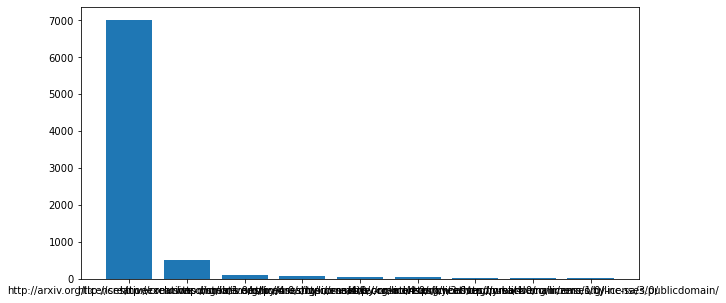

In [31]:
# create a count of each license type and plot
license_counts = df["license"].value_counts()

# plot
plt.figure(figsize=(10,5))
plt.bar(license_counts.index, license_counts.values)

In [30]:
license_counts

http://arxiv.org/licenses/nonexclusive-distrib/1.0/    7012
http://creativecommons.org/licenses/by/4.0/             510
http://creativecommons.org/licenses/by-nc-sa/4.0/        91
http://creativecommons.org/licenses/by-nc-nd/4.0/        79
http://creativecommons.org/licenses/by/3.0/              51
http://creativecommons.org/licenses/by-sa/4.0/           38
http://creativecommons.org/publicdomain/zero/1.0/        31
http://creativecommons.org/licenses/by-nc-sa/3.0/        28
http://creativecommons.org/licenses/publicdomain/        11
Name: license, dtype: int64

In [26]:
df[df["license"] == "http://creativecommons.org/publicdomain/zero/1.0/"].shape

(31, 14)

In [10]:
df.sample(frac=1).reset_index(drop=True)[:10]


,id,submitter,authors,title,comments,journal-ref,doi,report-no,categories,license,abstract,versions,update_date,authors_parsed
0,2106.01801,Ada Diaconescu Dr.,"Ada Diaconescu (1), Louisa Jane Di Felice (2),...",An Information-oriented Model of Multi-Scale (...,"7 pages, 3 Figures, presented at B-Series #5 o...",NaN,NaN,NaN,eess.SY cs.SY,http://creativecommons.org/licenses/by-nc-nd/4.0/,Multi-scale structures are prevalent in both...,"[{'version': 'v1', 'created': 'Thu, 3 Jun 2021...",2021-06-04,"[[Diaconescu, Ada, ], [Di Felice, Louisa Jane,..."
1,1306.6810,Irena Hinterleitner,I. Hinterleitner and J. Mike\v{s},Geodesic mappings of (pseudo-) Riemannian mani...,8 pages,NaN,NaN,NaN,math.DG,http://arxiv.org/licenses/nonexclusive-distrib...,In this paper we prove that geodesic mapping...,"[{'version': 'v1', 'created': 'Fri, 28 Jun 201...",2013-07-01,"[[Hinterleitner, I., ], [Mikeš, J., ]]"
2,1412.4186,Eugene Borovikov,Eugene Borovikov,An Evaluation of Support Vector Machines as a ...,A short (6 page) report on evaluation of the S...,NaN,NaN,NaN,cs.LG,http://creativecommons.org/licenses/publicdomain/,The purpose of this report is in examining t...,"[{'version': 'v1', 'created': 'Sat, 13 Dec 201...",2014-12-16,"[[Borovikov, Eugene, ]]"
3,cond-mat/0212455,Maciej M. Duras,Maciej M. Duras,Complex-valued second difference as a measure ...,"6 pages; ""Space-time chaos: Characterization, ...",NaN,NaN,NaN,cond-mat.stat-mech,NaN,A quantum statistical system with energy dis...,"[{'version': 'v1', 'created': 'Wed, 18 Dec 200...",2007-05-23,"[[Duras, Maciej M., ]]"
4,1905.10074,Lars Schlieper,"Alexander May, Lars Schlieper",Quantum Period Finding is Compression Robust,NaN,NaN,NaN,NaN,cs.CR quant-ph,http://arxiv.org/licenses/nonexclusive-distrib...,We study quantum period finding algorithms s...,"[{'version': 'v1', 'created': 'Fri, 24 May 201...",2021-02-16,"[[May, Alexander, ], [Schlieper, Lars, ]]"
5,2108.07603,Mark Henriksen,Mark J. Henriksen,The Origin of Intergalactic Light in Compact G...,"16 pages, 14 figures, 4 tables","Henriksen,M.J., The Origin of Intergalactic Li...",10.3390/universe7080303,NaN,astro-ph.CO astro-ph.GA,http://arxiv.org/licenses/nonexclusive-distrib...,We investigate the origin of intergalactic l...,"[{'version': 'v1', 'created': 'Tue, 17 Aug 202...",2021-08-18,"[[Henriksen, Mark J., ]]"
6,1105.4387,Kazuhiro Takemoto,Kazuhiro Takemoto,Global architecture of metabolite distribution...,"14 pages, 5 figures","Biosystems 100, 8 (2010)",10.1016/j.biosystems.2009.12.002,NaN,q-bio.PE physics.data-an,http://arxiv.org/licenses/nonexclusive-distrib...,Living organisms produce metabolites of many...,"[{'version': 'v1', 'created': 'Mon, 23 May 201...",2015-03-19,"[[Takemoto, Kazuhiro, ]]"
7,1401.0112,Zahid Raza,"Zahid Raza, Imran and Bijan Davvaz",On the Structure of Involutions and Symmetric ...,major revision,NaN,NaN,NaN,math.GR,http://arxiv.org/licenses/nonexclusive-distrib...,Let $G=QD_{8k}~$ be the quasi-dihedral group...,"[{'version': 'v1', 'created': 'Tue, 31 Dec 201...",2017-07-05,"[[Raza, Zahid, ], [Imran, , ], [Davvaz, Bijan, ]]"
8,1110.1206,Gary Gibbons,G.W. Gibbons,Anti-de-Sitter spacetime and its uses,"40 pp Latex, no figures Written version of lec...",NaN,NaN,NaN,hep-th gr-qc math-ph math.MP,http://arxiv.org/licenses/nonexclusive-distrib...,This is a pedagogic account of some of the g...,"[{'version': 'v1', 'created': 'Thu, 6 Oct 2011...",2011-10-07,"[[Gibbons, G. W., ]]"
9,1508.01999,Jian Zhou,Jian Zhou,Fermionic Computations for Integrable Hierarchies,NaN,NaN,NaN,NaN,math-ph math.MP,http://arxiv.org/licenses/nonexclusive-distrib...,We present a unified fermionic approach to c...,"[{'version': 'v1', 'created': 'Sun, 9 Aug 2015...",2015-08-11,"[[Zhou, Jian, ]]"


In [ ]:
# random shuffle and save only portion
df = df.sample(frac=1).reset_index(drop=True)
df = df[:10]